<a href="https://colab.research.google.com/github/raeubaen/ml/blob/master/MobileNet_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade imgaug

Requirement already up-to-date: imgaug in /usr/local/lib/python3.6/dist-packages (0.4.0)


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import os
import urllib
import re

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
IMG_SIZE = 96
def make_square(im, min_size=IMG_SIZE):
    x, y = im.size
    fill_color = im.getpixel((x-1, y-1))
    size = max(min_size, x, y)
    new_im = Image.new('RGB', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return np.asarray(new_im)

In [0]:
original_folder = "/content/drive/My Drive/Colab Notebooks/immagini_originali"

original_images = []
names = []
for file in os.listdir(original_folder):
  family = re.sub("stemma |.gif", "", re.sub("%20|%2520", " ", file.lower()))
  names.append(family)
  file_path = os.path.join(original_folder, file)
  array = make_square(Image.open(file_path).convert("RGB"))
  original_images.append(array)

In [0]:
'''
fig, ax_mat = plt.subplots(10, 10, figsize=(20, 20))
axs = np.ravel(ax_mat)
for i in range(100):
  axs[i].imshow(original_images[i])
  axs[i].set(title=names[i], xticks=[], yticks=[])
  
plt.show()
'''

'\nfig, ax_mat = plt.subplots(10, 10, figsize=(20, 20))\naxs = np.ravel(ax_mat)\nfor i in range(100):\n  axs[i].imshow(original_images[i])\n  axs[i].set(title=names[i], xticks=[], yticks=[])\n  \nplt.show()\n'

In [0]:
original_labels = tf.keras.utils.to_categorical(range(len(original_images)))

In [0]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.AdditiveGaussianNoise(scale=(0, 0.05)),
    iaa.Multiply((0.8, 1.2)),
    iaa.Cutout(nb_iterations=(0, 1), size=0.1),
    iaa.JpegCompression(compression=(0, 30)),
    iaa.GaussianBlur(sigma=(0, 1)),
    iaa.GammaContrast((0.5, 1.5)),
    iaa.Affine(scale={"x": (0.7, 1.3), "y": (0.7, 1.3)}),
    iaa.TranslateX(percent=(-0.1, 0.1)),
    iaa.TranslateY(percent=(-0.1, 0.1)),
    iaa.Rotate((-20, 20)),
    iaa.PerspectiveTransform(scale=(0, 0.15))
])


cloned_images = np.repeat(
  np.asarray(original_images), 30, axis=0,
)
cloned_labels = np.repeat(original_labels, 30, axis=0)

for i in range(len(cloned_images)//8): # così non finisce la ram...
  cloned_images[8*i : 8*(i+1)] = seq(
      images=cloned_images[8*i : 8*(i+1)]
  )

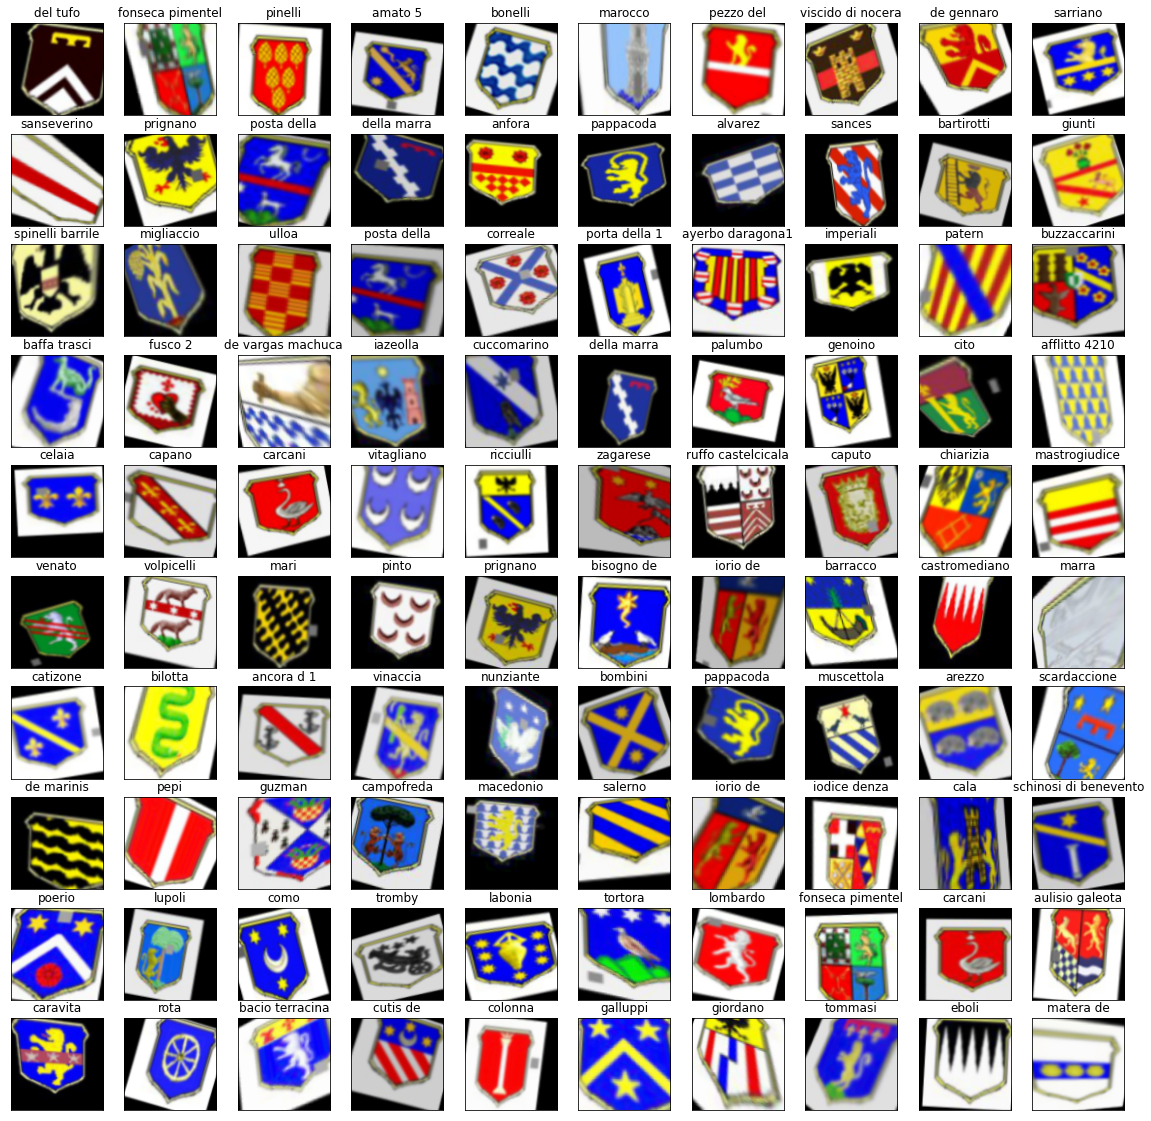

In [38]:
#example
rnd = np.random.randint(0, high=len(cloned_images), size=100)
fig, ax_mat = plt.subplots(10, 10, figsize=(20, 20))
axs = np.ravel(ax_mat)
for i in range(100):
  axs[i].imshow((cloned_images[rnd[i]]))
  axs[i].set(title = names[np.argmax(cloned_labels[rnd[i]])], xticks=[], yticks=[])
plt.show()

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test \
    = train_test_split(
        cloned_images.astype(np.float32)/127.5-1, 
        np.repeat(original_labels, 30, axis=0), 
        test_size=0.2, random_state=1
)

In [40]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
# Let's take a look at the base model architecture
base_model.trainable = False

# base_model.summary()

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [0]:
prediction_layer = tf.keras.layers.Dense(584, activation="softmax")

In [0]:
with tf.device("/gpu:0"):
  model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
  ])

In [0]:
base_learning_rate = 0.0001
with tf.device("/gpu:0"):
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 584)               748104    
Total params: 3,006,088
Trainable params: 748,104
Non-trainable params: 2,257,984
_________________________________________________________________


In [47]:
!nvidia-smi
print(tf.test.gpu_device_name())
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Tue Apr 28 09:25:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    31W / 250W |    385MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18330855916653612343, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 409474476680489342
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1627856722788985115
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701463552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5067728439057951651
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [50]:
BATCH_SIZE = 128
with tf.device("/gpu:0"):
  history = model.fit(x=X_train, y=Y_train,
                      epochs=300,
                      validation_split=0.25, batch_size=BATCH_SIZE)

Epoch 1/300
83/83 [==============================] - 3s 33ms/step - loss: 0.6925 - accuracy: 0.9937 - val_loss: 0.6927 - val_accuracy: 0.9446
Epoch 2/300
83/83 [==============================] - 3s 32ms/step - loss: 0.6925 - accuracy: 0.9942 - val_loss: 0.6927 - val_accuracy: 0.9435
Epoch 3/300
83/83 [==============================] - 3s 32ms/step - loss: 0.6925 - accuracy: 0.9949 - val_loss: 0.6927 - val_accuracy: 0.9432
Epoch 4/300
83/83 [==============================] - 3s 33ms/step - loss: 0.6925 - accuracy: 0.9951 - val_loss: 0.6927 - val_accuracy: 0.9432
Epoch 5/300
83/83 [==============================] - 3s 32ms/step - loss: 0.6925 - accuracy: 0.9951 - val_loss: 0.6927 - val_accuracy: 0.9438
Epoch 6/300
83/83 [==============================] - 3s 32ms/step - loss: 0.6925 - accuracy: 0.9952 - val_loss: 0.6927 - val_accuracy: 0.9438
Epoch 7/300
83/83 [==============================] - 3s 32ms/step - loss: 0.6925 - accuracy: 0.9952 - val_loss: 0.6927 - val_accuracy: 0.9435
Epoch 

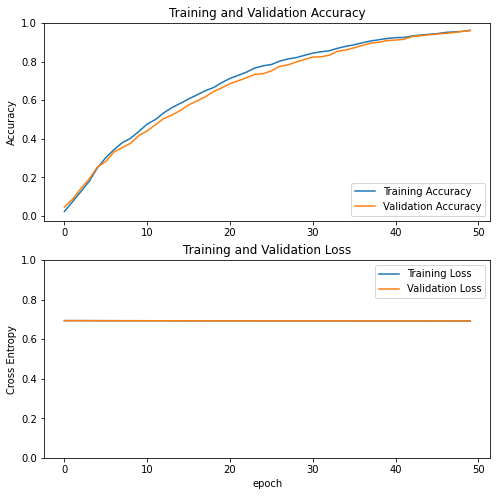

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()